# Evaluation of SFINCS vs HAND

Let's plot the HAND output for this location
- Generated from FIM-C PI3 TP! Subcase 2
`python retro_flows.py --fim-version PI3_fim60_10m_wbt --huc 11070103 --date-range 2019-05-20 2019-05-29`"

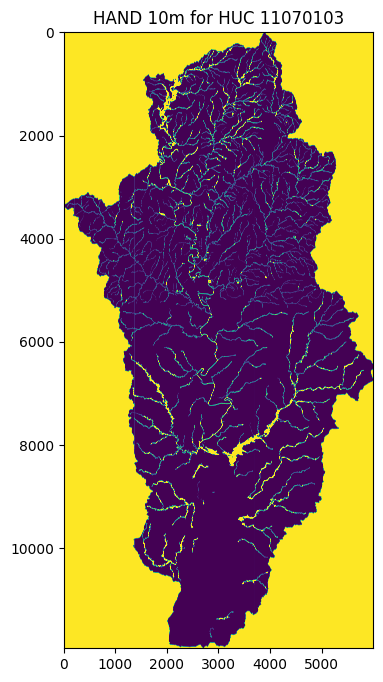

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import rasterio
import rioxarray as rxr
import geopandas as gpd
from shapely.geometry import Point

hand_tif = "/app/data/SFINCS/ngwpc_data/gis/11070103_retro_inundation_v2.tif"

# Open the file
with rasterio.open(hand_tif) as src:
    # Read the data
    data = src.read(1)  # Read the first band
    
    # Create a masked array
    masked_data = ma.masked_equal(data, 255)
    
    # Get the actual min and max values, ignoring no-data
    vmin, vmax = np.percentile(masked_data.compressed(), [2, 98])
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot the data with improved color scaling
    im = ax.imshow(masked_data, cmap='viridis', vmin=vmin, vmax=vmax)
    
    # Set the title
    ax.set_title('HAND 10m for HUC 11070103')
    
    # Show the plot
    plt.show()

We need to convert this to a binary mask

In [2]:
output_binary_tif = "/app/data/SFINCS/ngwpc_data/gis/output_binary_hand_v2.tif"
with rasterio.open(hand_tif) as src:
    band_data = src.read(1)
    nodata = src.nodata
    
    if nodata is not None:
        valid_data_mask = band_data != nodata
        binary_data = np.full_like(band_data, 255, dtype=np.uint8)
        binary_data[np.logical_and(band_data <= 0, valid_data_mask)] = 0
        binary_data[np.logical_and(band_data > 0, valid_data_mask)] = 1
    else:
        binary_data = (band_data > 0).astype(np.uint8)
    
    profile = src.profile
    profile.update(dtype=rasterio.uint8, count=1, compress='lzw', nodata=255)
    
    with rasterio.open(output_binary_tif, 'w', **profile) as dst:
        dst.write(binary_data, 1)

### Let's zoom in on the area of interest to see how HAND mapped the event

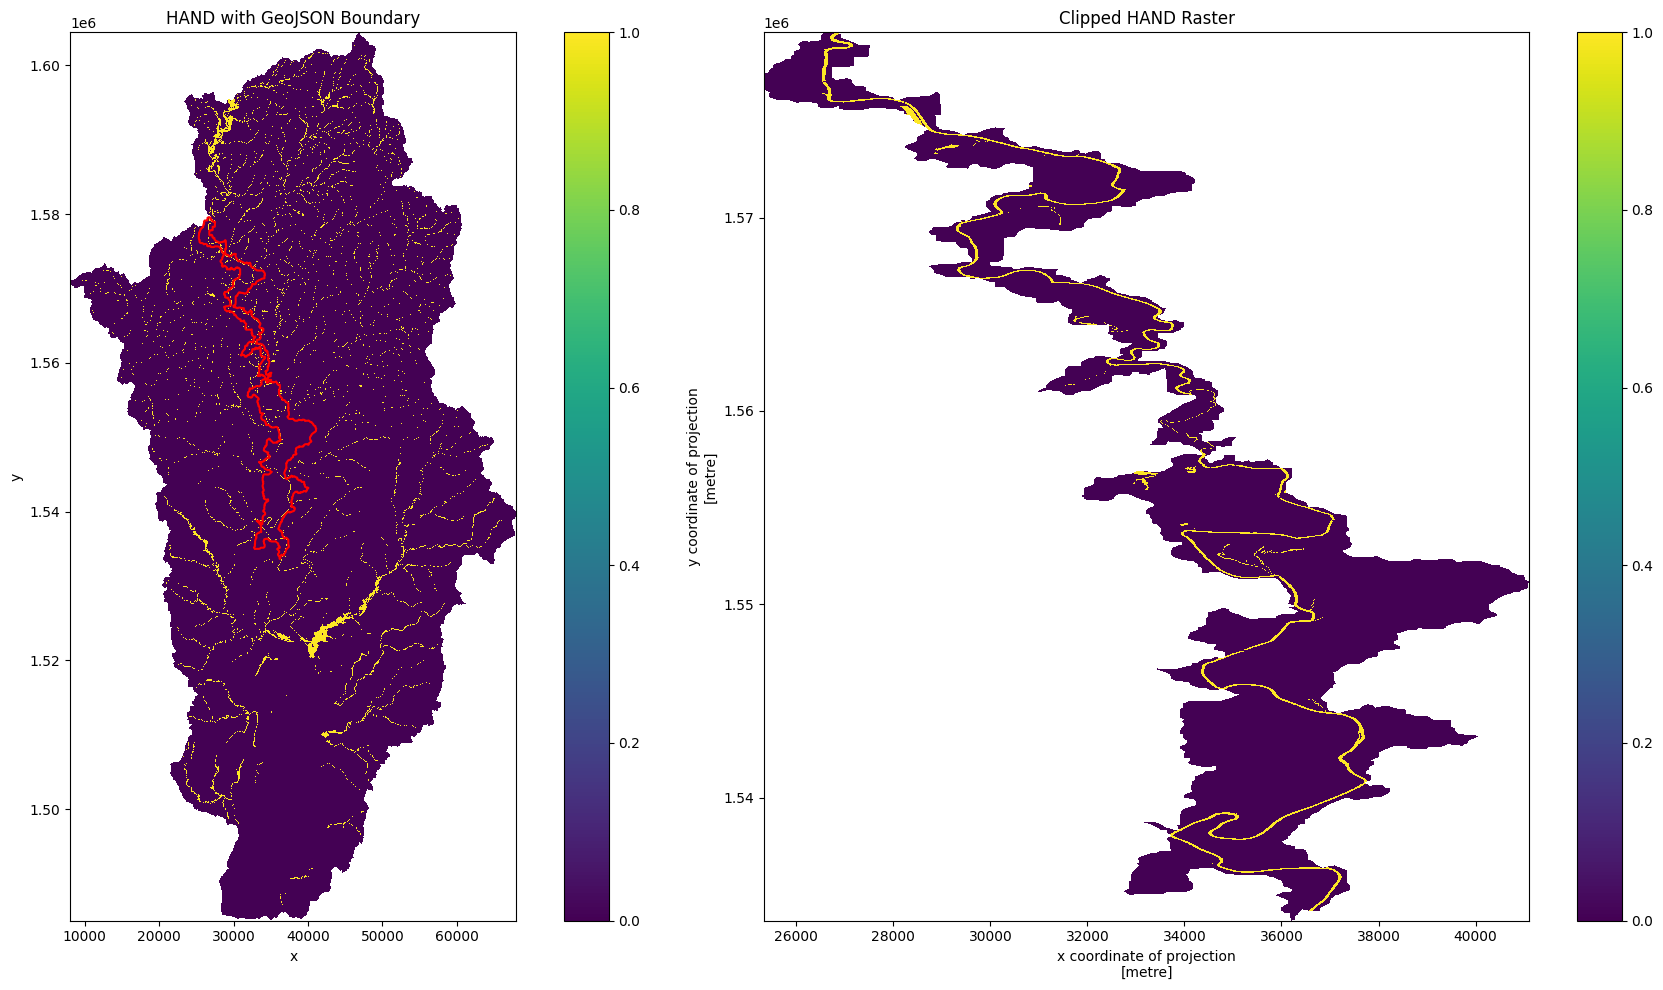

In [3]:
import rioxarray as rxr
import geopandas as gpd

clipped_path = "/app/data/SFINCS/ngwpc_data/gis/output_binary_hand_clipped.tif"
raster_large_hand = rxr.open_rasterio(output_binary_tif)

if raster_large_hand.shape[0] > 1:
    raster_large_hand = raster_large_hand[0]

# Set the no-data value
raster_large_hand = raster_large_hand.where(raster_large_hand != 255)

# Read the GeoJSON file
gdf_hand = gpd.read_file("/app/data/NWM/flowlines_divides.geojson")

# Ensure the GeoDataFrame has the same CRS as the raster
gdf_hand = gdf_hand.to_crs(raster_large_hand.rio.crs)

# Clip the raster with the GeoJSON geometry
clipped_hand = raster_large_hand.rio.clip(gdf_hand.geometry, gdf_hand.crs)
clipped_hand.rio.to_raster(clipped_path, dtype="uint8")

clipped_hand = clipped_hand.where(clipped_hand != 255)

# Plot the result
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot original raster
im1 = raster_large_hand.plot(ax=ax1, cmap='viridis', vmin=raster_large_hand.min(), vmax=raster_large_hand.max())
gdf_hand.boundary.plot(ax=ax1, color='red')
ax1.set_title('HAND with GeoJSON Boundary')

# Plot clipped raster
im2 = clipped_hand.plot(ax=ax2, cmap='viridis', vmin=clipped_hand.min(), vmax=clipped_hand.max())
ax2.set_title('Clipped HAND Raster')

plt.tight_layout()
plt.show()

### Let's see the SFINCS output in this location

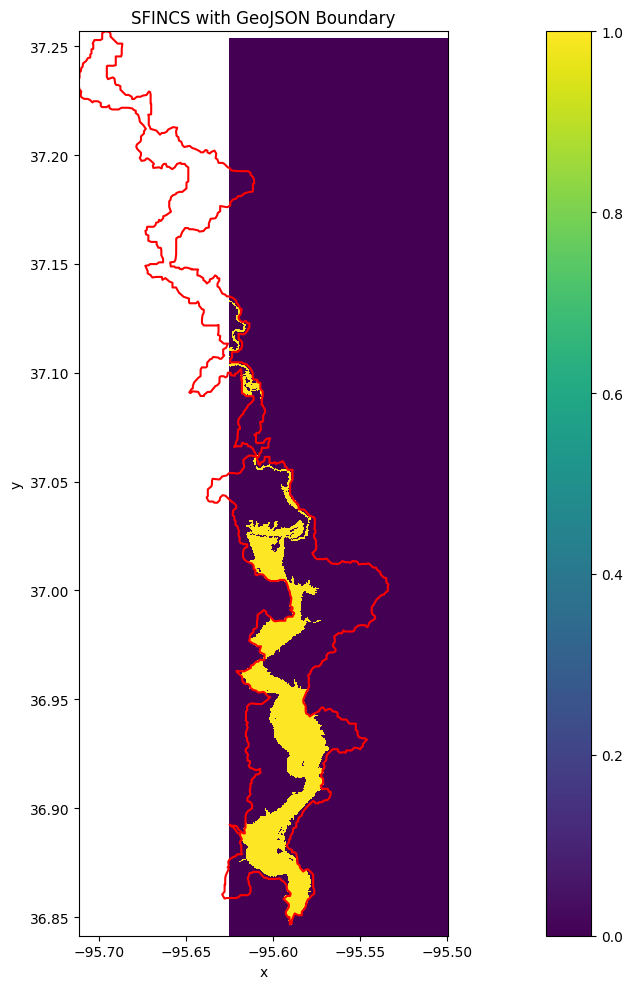

In [4]:
import rioxarray as rxr
import geopandas as gpd

sfincs_tif = "/app/data/SFINCS/ngwpc_data/gis/output_binary_sfincs.tif"
raster_sfincs = rxr.open_rasterio(sfincs_tif)

if raster_sfincs.shape[0] > 1:
    raster_sfincs = raster_sfincs[0]

# Set the no-data value
raster_sfincs = raster_sfincs.where(raster_sfincs != 255)

nan_mask = np.isnan(raster_sfincs.values)
raster_sfincs.values[nan_mask] = 0

# Read the GeoJSON file
gdf = gpd.read_file("/app/data/NWM/flowlines_divides.geojson")

# Ensure the GeoDataFrame has the same CRS as the raster
gdf = gdf.to_crs(raster_sfincs.rio.crs)

# # Clip the raster with the GeoJSON geometry
# clipped_sfincs = raster_sfincs.rio.clip(gdf.geometry, gdf.crs)

# clipped_sfincs = clipped_sfincs.where(clipped_sfincs != 255)

# Plot the result
fig, ax1 = plt.subplots(1, 1, figsize=(20, 10))

# Plot original raster
im1 = raster_sfincs.plot(ax=ax1, cmap='viridis')
gdf.boundary.plot(ax=ax1, color='red')
ax1.set_title('SFINCS with GeoJSON Boundary')

minx, miny, maxx, maxy = gdf.total_bounds
ax1.set_xlim(min(raster_sfincs.x.min(), minx), max(raster_sfincs.x.max(), maxx))
ax1.set_ylim(min(raster_sfincs.y.min(), miny), max(raster_sfincs.y.max(), maxy))

# # Plot clipped raster
# im2 = clipped.plot(ax=ax2, cmap='viridis', vmin=clipped.min(), vmax=clipped.max())
# ax2.set_title('Clipped SFINCS Raster')

plt.tight_layout()
plt.show()

### Let's add high water marks from USGS

In [5]:
usgs_hwm = gpd.read_file("/app/data/SFINCS/ngwpc_data/gis/Central_US_Spring_2019.gpkg")
usgs_hwm = usgs_hwm.to_crs(epsg=5070)
usgs_hwm.head()

,latitude_dd,longitude_dd,latitude,longitude,eventName,hwmTypeName,hwmQualityName,verticalDatumName,verticalMethodName,markerName,...,approval,files,site,vertical_datums,Links,lat4326,lon4326,adj_elev_ft,datum_offset_ft,geometry
0,40.603332,-95.647591,40.603332,-95.647591,Central US Spring 2019,Other (Note in Description box),Unknown/Historical,NAVD88,Other (Note in Description box),Other (Note in Description box),...,None,System.Collections.Generic.HashSet`1[STNDB.file],None,None,None,40.603332,-95.647591,918.23,0.0,POINT (29571.069 1954622.471)
1,40.607820,-95.650145,40.607820,-95.650145,Central US Spring 2019,Other (Note in Description box),Unknown/Historical,NAVD88,Other (Note in Description box),Other (Note in Description box),...,None,System.Collections.Generic.HashSet`1[STNDB.file],None,None,None,40.607820,-95.650145,917.42,0.0,POINT (29354.896 1955124.426)
2,40.601714,-95.647100,40.601714,-95.647100,Central US Spring 2019,Other (Note in Description box),Unknown/Historical,NAVD88,Other (Note in Description box),Other (Note in Description box),...,None,System.Collections.Generic.HashSet`1[STNDB.file],None,None,None,40.601714,-95.647100,917.17,0.0,POINT (29612.971 1954441.462)
3,40.606395,-95.649510,40.606395,-95.649510,Central US Spring 2019,Other (Note in Description box),Unknown/Historical,NAVD88,Other (Note in Description box),Other (Note in Description box),...,None,System.Collections.Generic.HashSet`1[STNDB.file],None,None,None,40.606395,-95.649510,918.24,0.0,POINT (29408.814 1954965.015)
4,40.592308,-95.644152,40.592308,-95.644152,Central US Spring 2019,Other (Note in Description box),Unknown/Historical,NAVD88,Other (Note in Description box),Other (Note in Description box),...,None,System.Collections.Generic.HashSet`1[STNDB.file],None,None,None,40.592308,-95.644152,917.76,0.0,POINT (29864.226 1953388.804)


### Let's add Sentinel-2 flood extent data from 5/27/19

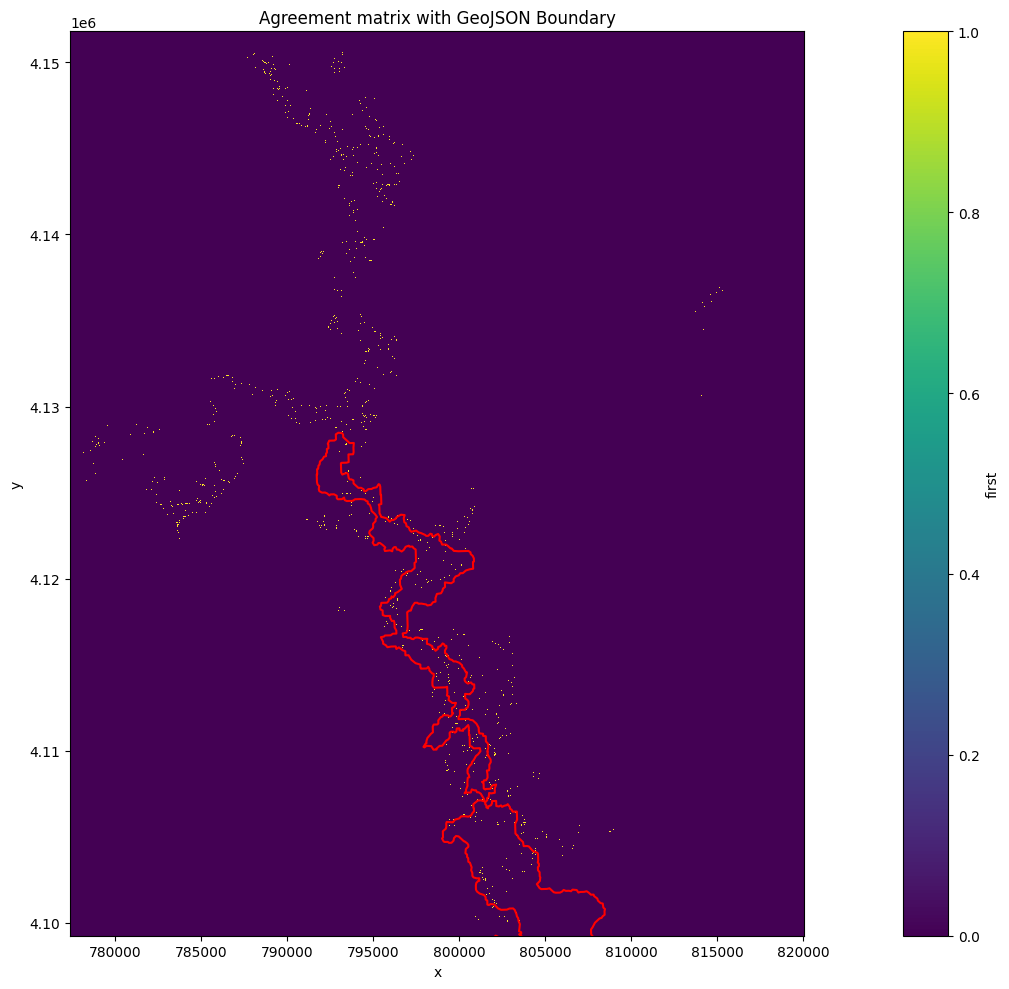

In [6]:
from shapely.geometry import box

raster_rs = rxr.open_rasterio("/app/data/SFINCS/ngwpc_data/gis/coffeyville_flood_extent.tif")
if raster_rs.shape[0] > 1:
    raster_rs = raster_rs[0]

# Set the no-data value
raster_rs = raster_rs.where(raster_rs != 255)

# Read the GeoJSON file
gdf = gpd.read_file("/app/data/NWM/flowlines_divides.geojson")

# Ensure the GeoDataFrame has the same CRS as the raster
gdf = gdf.to_crs(raster_rs.rio.crs)

# Plot the result
fig, ax1 = plt.subplots(1, 1, figsize=(20, 10))

# Plot original raster
im1 = raster_rs.plot(ax=ax1, cmap='viridis')
gdf.boundary.plot(ax=ax1, color='red')
ax1.set_title('Agreement matrix with GeoJSON Boundary')

# # Plot clipped raster
# im2 = clipped.plot(ax=ax2, cmap='viridis', vmin=clipped.min(), vmax=clipped.max())
# ax2.set_title('Clipped SFINCS Raster')

plt.tight_layout()
plt.show()

In [7]:
huc_8_data = gpd.read_file("/app/data/NWM/huc8s_sp.gpkg")
subset  = huc_8_data[huc_8_data["HUC8"] == "11070103"]
geojson_rs = gpd.read_file("/app/data/SFINCS/ngwpc_data/gis/coffeyville_flood_extent.geojson")

In [8]:
geojson_rs = geojson_rs.to_crs(subset.crs)
sentinel = gpd.sjoin(geojson_rs, subset, how="inner", predicate="within")
sentinel = sentinel.reset_index(drop=True)
sentinel.crs

<Projected CRS: EPSG:5070>
Name: NAD83 / Conus Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - CONUS onshore - Alabama; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming.
- bounds: (-124.79, 24.41, -66.91, 49.38)
Coordinate Operation:
- name: Conus Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [9]:
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 85.9 MB/s eta 0:00:00:00:0100:01


In [10]:
from sklearn.cluster import DBSCAN
def simplify_points(gdf, eps=0.001, min_samples=1):
    gdf_wgs84 = gdf.to_crs("EPSG:4326")
    coords = np.array([(geom.x, geom.y) for geom in gdf_wgs84.geometry])
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(coords)
    gdf_wgs84['cluster'] = db.labels_
    simplified = gdf_wgs84.dissolve(by='cluster', aggfunc='first').reset_index(drop=True)
    return simplified.to_crs(gdf.crs)

# Simplify Sentinel data
sentinel_simplified = simplify_points(sentinel, eps=0.001, min_samples=1)
print(f"Original Sentinel points: {len(sentinel)}")
print(f"Simplified Sentinel points: {len(sentinel_simplified)}")

Original Sentinel points: 22881
Simplified Sentinel points: 738


### Let's plot everything on one pane

In [11]:
_gdf = gpd.read_file("/app/data/NWM/flowlines_divides.geojson")
src_points = gpd.read_file("/app/data/SFINCS/ngwpc_data/gis/inflow_points.gpkg").to_crs(raster_sfincs.rio.crs)

/opt/conda/lib/python3.11/site-packages/geopandas/plotting.py:482: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  ax.figure.canvas.draw_idle()
/tmp/ipykernel_8460/1120139348.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


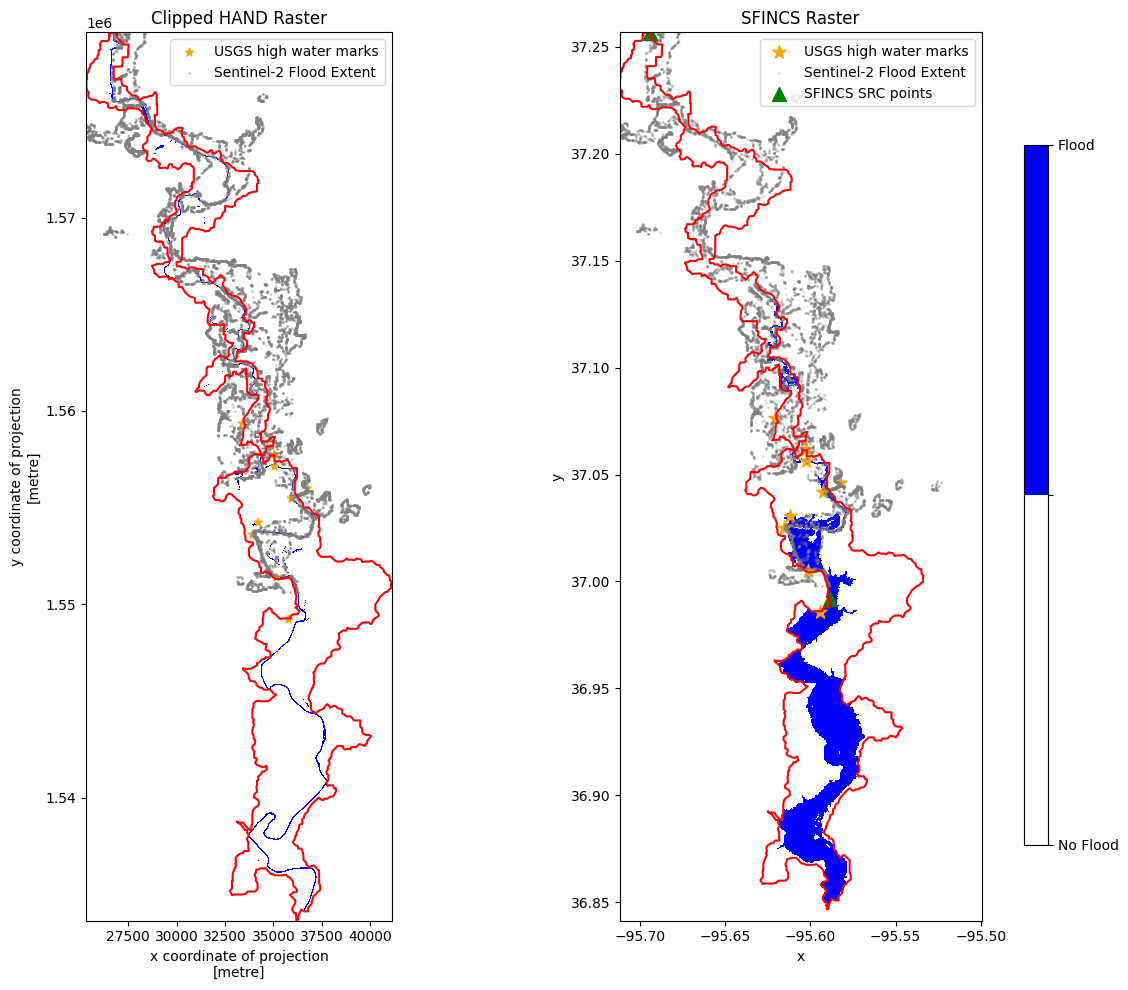

In [12]:
import matplotlib.colors as colors
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))

cmap = colors.ListedColormap(['white', 'blue'])
bounds = [0, 0.5, 1]
norm = colors.BoundaryNorm(bounds, cmap.N)

im1 = clipped_hand.plot(ax=ax1, cmap=cmap, norm=norm, vmin=clipped_hand.min(), vmax=clipped_hand.max(), add_colorbar=False)
_gdf.to_crs(clipped_hand.rio.crs).boundary.plot(ax=ax1, color='red')
usgs_hwm.to_crs(clipped_hand.rio.crs).plot(ax=ax1, color='orange', label="USGS high water marks", marker="*")
sentinel.to_crs(clipped_hand.rio.crs).plot(ax=ax1, color='grey', label="Sentinel-2 Flood Extent", markersize=1, alpha=0.3)
ax1.set_title('Clipped HAND Raster')
ax1.legend()

im2 = raster_sfincs.plot(ax=ax2, cmap=cmap, norm=norm, add_colorbar=False)
_gdf.to_crs(raster_sfincs.rio.crs).boundary.plot(ax=ax2, color='red')
usgs_hwm.to_crs(raster_sfincs.rio.crs).plot(ax=ax2, color='orange', label="USGS high water marks", marker="*", markersize=100)
sentinel.to_crs(raster_sfincs.rio.crs).plot(ax=ax2, color='grey', label="Sentinel-2 Flood Extent", marker="o", markersize=1, alpha=0.2)
src_points.plot(ax=ax2, color='green', label="SFINCS SRC points", marker="^", markersize=100)

minx, miny, maxx, maxy = _gdf.to_crs(raster_sfincs.rio.crs).total_bounds
ax2.set_xlim(min(raster_sfincs.x.min(), minx), max(raster_sfincs.x.max(), maxx))
ax2.set_ylim(min(raster_sfincs.y.min(), miny), max(raster_sfincs.y.max(), maxy))
ax2.set_title('SFINCS Raster')
ax2.legend(loc="upper right")

# Create a single colorbar for the entire figure
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(im2, cax=cbar_ax)

# Define your custom tick locations and labels
tick_locations = [0, 0.5, 1]
tick_labels = ['No Flood', '', 'Flood']

# Set the tick locations and labels
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)

plt.tight_layout()
plt.show()

### LEGEND:
#### Blue = Flood
#### Grey points = Sentinel Flood Extent
#### Green Triangles = SFINCS SRC points
#### Orange Stars = USGS HWM

### Conclusions

We can see that SFINCS is able to generate higher flows than HAND. We suspect this is due to a lack of subgrid definition (roughness, channel width, channel depth. We are coordinating with Deltares' HydroMT and SFINCS teams in order to get subgrid definitions working with the latest docker images. 